In [1]:
#Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Load and preprocess images
# This function sets the transform,max size and shape of the content and style image

def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size is not None:
        image.thumbnail((max_size, max_size))
    if shape is not None:
        image = image.resize(shape, Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image.to(device)


In [3]:
# Defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Declaring the transformation values that will be used in the 'load_image' function

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [5]:
# Loading the content
#setting the max size value to be preprocessed in the 'load_image' function
content_image = load_image("output9.jpg", transform, max_size=1000)

#loading the style image
#setting the size to be the same as the content image
style_image = load_image("pic1.jpg", transform, shape=[content_image.size(2), content_image.size(3)])

# Initialize the target image as a copy of the content image
target_image = content_image.clone().requires_grad_(True)



<h1 class="alert-info">
Content Image
</h1>


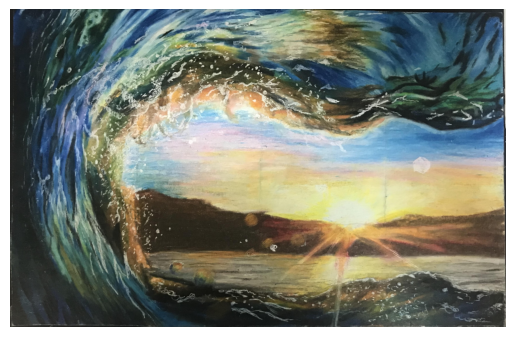

In [6]:
#Displaying the content image
content = Image.open("output9.jpg")
plt.imshow(content)
plt.axis('off')  
plt.show()

<h1 class="alert-info">
Content Image
</h1>


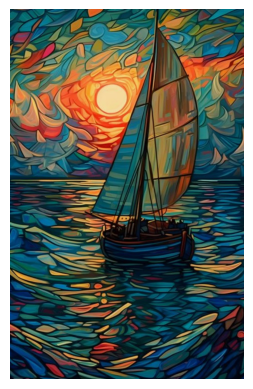

In [7]:
#Displaying the style image
style = Image.open("pic1.jpg")
plt.imshow(style)
plt.axis('off')  
plt.show()

In [8]:
# Defining the VGG19 model
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.vgg_layers = models.vgg19(pretrained=True).features
        for param in self.vgg_layers.parameters():
            param.requires_grad_(False)

    def forward(self, x):
        features = []
        for layer_name, layer in enumerate(self.vgg_layers):
            x = layer(x)
            if layer_name in {1, 6, 11, 20, 29}: 
                features.append(x)
        return features

vgg = VGGNet().to(device).eval()

C:\Users\65911\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\65911\anaconda3\envs\tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define content and style layer names
content_layer = 'conv4_2'  
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_2', 'conv5_1']  



In [10]:
# Define the loss function

#Content loss
def content_loss(content, target):
    return torch.mean((content - target) ** 2)

#gram matrix
def gram_matrix(x):
    _, c, h, w = x.size()
    x = x.view(c, h * w)
    gram = torch.mm(x, x.t())
    return gram

#style loss
def style_loss(style, target):
    return torch.mean((gram_matrix(style) - gram_matrix(target)) ** 2)



In [11]:
# Set up the optimization

#Controls the content loss
content_weight = 100
#Controls the style loss
style_weight = 500  
optimizer = optim.LBFGS([target_image])



In [12]:
# Style transfer optimization loop 

#no:of iterations
num_steps = 100
for step in range(num_steps):
    def closure():
        optimizer.zero_grad()
        target_features = vgg(target_image)
        content_features = vgg(content_image)
        style_features = vgg(style_image)

        loss = 0

        #  content loss
        #gets created every iteration
        loss += content_weight * content_loss(target_features[style_layers.index(content_layer)], content_features[style_layers.index(content_layer)])

        #  style loss
        for layer in style_layers:
            style_feature = style_features[style_layers.index(layer)]
            target_feature = target_features[style_layers.index(layer)]
            loss += style_weight * style_loss(style_feature, target_feature)

        loss.backward()
        return loss

    #prints out the under of iterations every 20 iterations
    optimizer.step(closure)
    if step % 20 == 0:
        print(f"Step [{step}/{num_steps}]")


Step [0/1]


In [13]:
# Saving the final stylized image
output_image = target_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
output_image = (output_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
output_image = (output_image * 255.0).clip(0, 255).astype(np.uint8)
#image is saved under the following file location
Image.fromarray(output_image).save("output7.jpg")


<h1 class="alert-info">
Stylised Image
</h1>


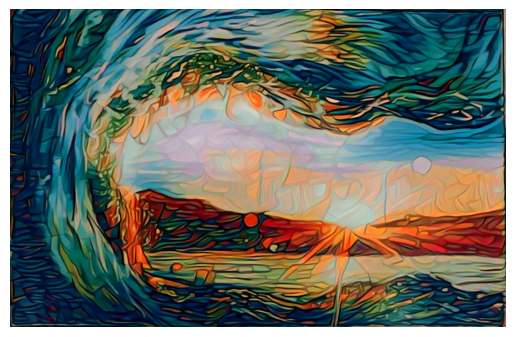

In [14]:
#Stylished image is displayed
from matplotlib import pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.imshow(np.squeeze(output_image))
plt.axis('off')  
plt.show()

###### 